# Standard Imports

In [1246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

# Constants

In [1247]:
seed = 42

# Import data

In [1248]:
# Chemical and Instrumental Assessment of Green Tea Sensory Preference - Y.R. Liang, Q. Ye, J. Jin, H. Liang, J.L. Lu, Y.Y. Du & J.J. Dong
# https://doi.org/10.1080/10942910701299430
# Notes: downloaded CSVs

df_10942910701299430_chemical_composition = pd.read_csv('../data/10942910701299430/chemical_composition.csv', index_col=0, header=1)
df_10942910701299430_sensory_evaluation = pd.read_csv('../data/10942910701299430/sensory_evaluation.csv')

# Phytochemical Composition and Antioxidant Capacity of 30 Chinese Teas - by Guo-Yi Tang, Cai-Ning Zhao, Xiao-Yu Xu, Ren-You Gan, Shi-Yu Cao, Qing Liu, AoShang, Qian-Qian Mao & Hua-Bin Li
# https://doi.org/10.3390/antiox8060180
# Notes: Manually scraped data

df_antiox8060180_chemical_composition = pd.read_csv('../data/antiox8060180/chemical_composition.csv')

# Catechin and caffeine content of tea (Camellia sinensis L.) leaf significantly differ with seasonal variation... - Himangshu Deka, Tupu Barman, Jintu Dutta, Arundhuti Devi, Pradip Tamuly, Ranjit Kumar Paul & Tanmoy Karak 
# https://doi.org/10.1016/j.jfca.2020.103684
# https://krishi.icar.gov.in/jspui/bitstream/123456789/68751/2/S0889157520313892-main.pdf - Free access

# df_j.jfca.2020.103684_chemical_composition = pd.read_csv('dava/j.jfca.2020.103684/chemical_composition.csv')

# Comparative analysis of tea catechins and theaflavins by high-performance liquid chromatography and capillary electrophoresis - Bee-Lan Lee & Choon-Nam Ong
# https://doi.org/10.1016/S0021-9673(00)00215-6
# Notes: Manually scraped data

df_S0021967300002156 = pd.read_csv('../data/S0021967300002156/chemical_composition.csv')

# Survey of Catechins, Gallic Acid, and Methylxanthines in Green, Oolong, Pu-erh, and Black Teas - Jen-Kun Lin, Chih-Li Lin, Yu-Chih Liang, Shoei-Yn Lin-Shiau & I-Ming Juan
# https://doi.org/10.1021/jf980223x
# Notes: Manually scraped data

df_jf980223x = pd.read_csv('../data/jf980223x/chemical_composition.csv')


In [1249]:
# List of all imported dataframes
all_dataframes = [df_10942910701299430_chemical_composition,
                  df_10942910701299430_sensory_evaluation,
                  df_antiox8060180_chemical_composition,
                  df_S0021967300002156,
                  df_jf980223x]

# Combine data

To combine the data I am going to create a data pipeline that does the following:

1. Add all the pandas dataframes to a list.
2. Read that list into a function.
3. The function reads an individual dataframe from that list then resets the index, rename catechins to be like the catechin dictionary below, drop unused columns, add columns that are part of the standardized column format, and then sorts the columns to be part of the standardized column format.
4. The function will then add the dataframe to a list denoting it is processed.
5. Once the function has processed all the dataframes in the lists it will loop through the data frames in the finished list and concatenate them.
6. The function will return a combined dataframe.

## Data Frame Format

The data frames will be combined into the following format:

- `'Catechin'`
- `'Epicatechin'`
- `'Gallocatechin'`
- `'Epigallocatechin'`
- `'Catechin Gallate'`
- `'Epicatechin Gallate'`
- `'Gallocatechin Gallate'`
- `'Epigallocatechin Gallate'`
- `'Gallic Acid'`
- `'Chlorogenic Acid'`
- `'Caffeine'`
- `'Taste'`
- `'Appearance'`
- `'Aroma'`
- `'Liqour color'`


In [1250]:
catechin_dictionary = {
    'C': 'Catechin',
    'EC': 'Epicatechin',
    'GC': 'Gallocatechin',
    'EGC': 'Epigallocatechin',
    'CG': 'Catechin Gallate',
    'ECG': 'Epicatechin Gallate',
    'GCG': 'Gallocatechin Gallate',
    'EGCG': 'Epigallocatechin Gallate'
}

standardized_columns = [
    'Catechin',
    'Epicatechin',
    'Gallocatechin',
    'Epigallocatechin',
    'Catechin Gallate',
    'Epicatechin Gallate',
    'Gallocatechin Gallate',
    'Epigallocatechin Gallate',
    'Gallic Acid',
    'Chlorogenic Acid',
    'Caffeine',
    'Taste',
    'Appearance',
    'Aroma',
    'Liqour color'
]

In [1251]:
df_jf980223x['EC'].dtype == 'float64'

True

To faciliate scability I am create a sklearn pipeline and process all my data to be concatenated.
First I will define the functions that will go into my data preprocessing pipeline.

In [1252]:
def reset_index(dataframe: pd.DataFrame):
    return dataframe.reset_index(drop=1)

def rename_columns(dataframe: pd.DataFrame):
    return dataframe.rename(columns=catechin_dictionary)

def drop_nonstandardized_columns(dataframe: pd.DataFrame):
    return dataframe.drop(columns=[column for column in dataframe if column not in standardized_columns])

def reformat_columns(dataframe: pd.DataFrame):
    return dataframe.reindex(columns=standardized_columns)

def remove_standard_deviation_format(dataframe: pd.DataFrame):
    for column in range(len(dataframe)):
        if (dataframe.iloc[column].dtype == 'object') or (dataframe.iloc[column].dtype == 'string'):
            dataframe.iloc[column] = dataframe.iloc[column].str.replace('± \d*.\d*', '', regex=True)
    return dataframe    

Next, the data pipeline applies all of those functions to the inputed dataset.

In [1253]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

ResetIndexTransformer = FunctionTransformer(reset_index)
RenameColumnsTransformer = FunctionTransformer(rename_columns)
DropNonstandardizedColumnsTransformer = FunctionTransformer(drop_nonstandardized_columns)
ReformatColumnsTransformer = FunctionTransformer(reformat_columns)
RemoveStandardDeviationFormat = FunctionTransformer(remove_standard_deviation_format)

data_combining_pipeline = make_pipeline(
    ResetIndexTransformer,
    RenameColumnsTransformer,
    DropNonstandardizedColumnsTransformer,
    ReformatColumnsTransformer,
    RemoveStandardDeviationFormat
)


Now I am creating a pipeline that transforms each dataframe then concatenates it and returns one dataframe to be used for the model.

In [1254]:
def process_dataframes(dataframes: list):
    processed_dataframes = []
    for dataframe in dataframes:
        dataframe = data_combining_pipeline.fit_transform(dataframe)
        processed_dataframes.append(dataframe)
    return processed_dataframes

def concatenate_dataframes(dataframes: list):
    formated_dataframe = pd.concat(dataframes, ignore_index=True)
    return formated_dataframe

def change_dtypes(dataframe: pd.DataFrame):
    for column in df.columns:
        dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')
    return dataframe

In [1255]:
ProcessDataframes = FunctionTransformer(process_dataframes)
ConcatenateDataframes = FunctionTransformer(concatenate_dataframes)
Change_Dtypes = FunctionTransformer(change_dtypes)

data_combining_pipeline_processor = make_pipeline(
    ProcessDataframes,
    ConcatenateDataframes,
    Change_Dtypes
)

In [1256]:
df = data_combining_pipeline_processor.transform(all_dataframes)

# Exploratory Data Analysis


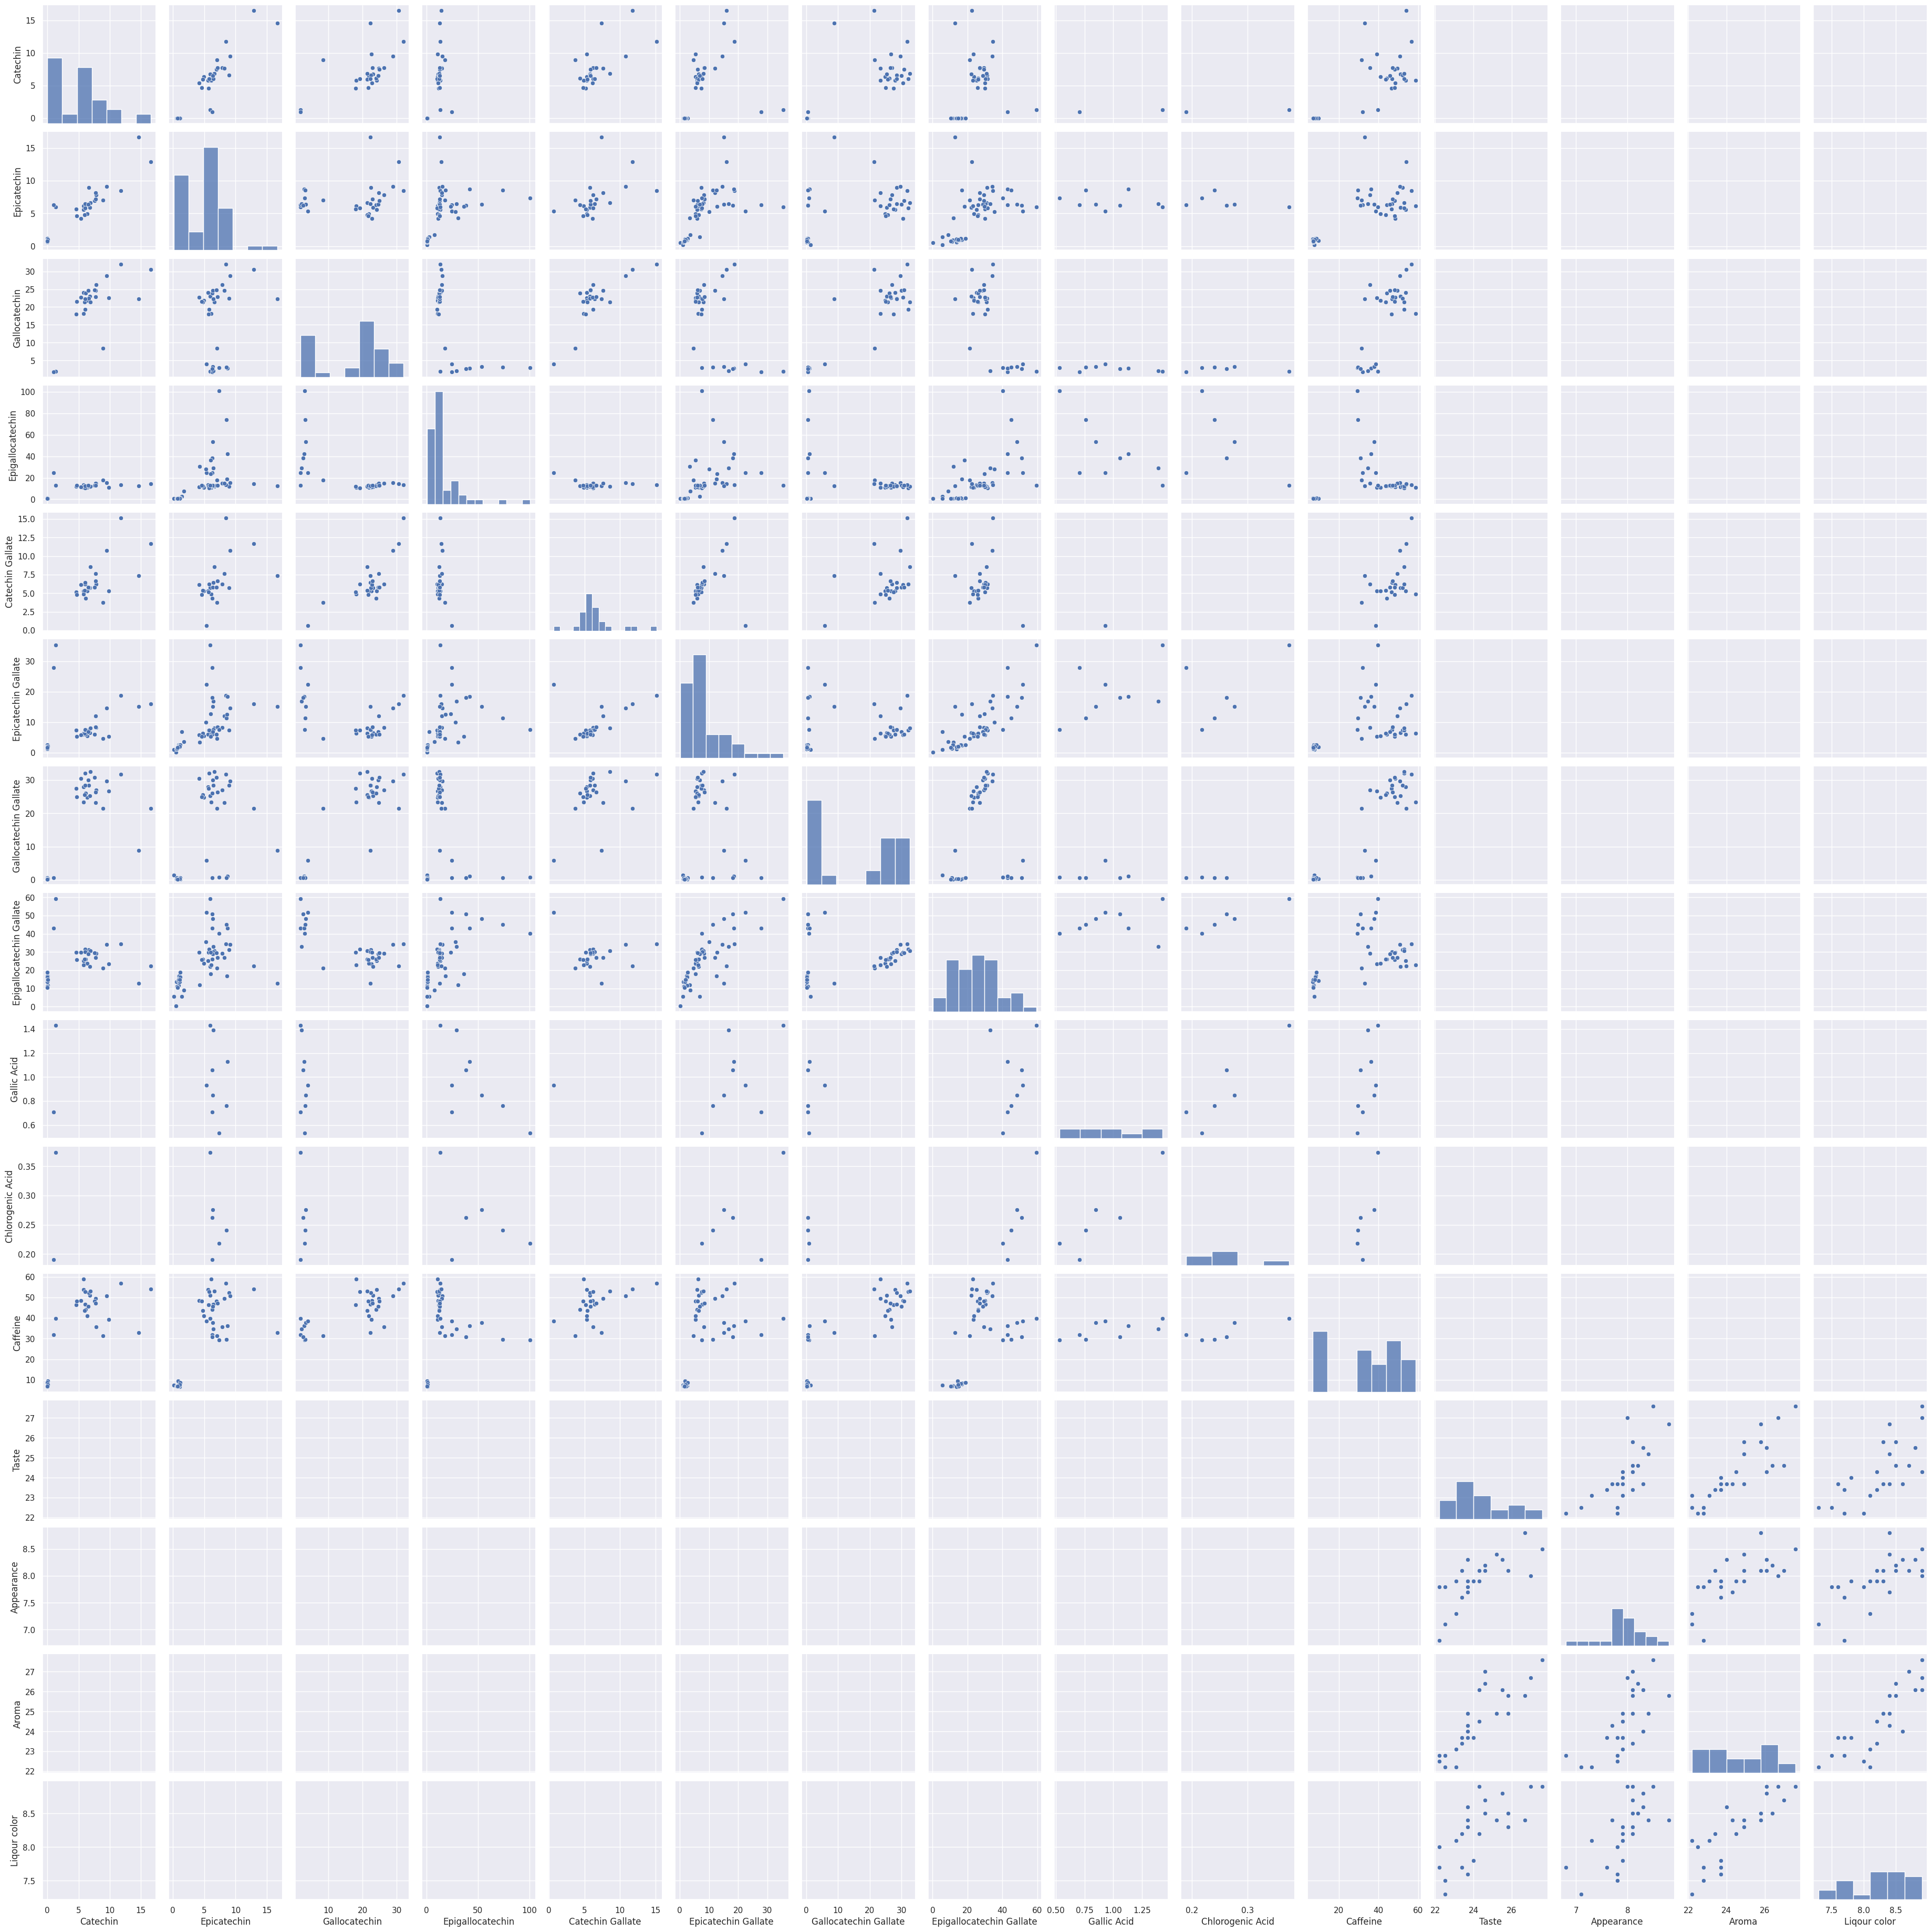

In [1257]:
sns.set_theme()
sns.pairplot(df)

# Data Wrangling

# Training Device

In [1258]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Generative Adversarial Network

In [1259]:
class Generator(nn.Module):
    def __init__(self, ngpu):
            super(Generator, self).__init__()
            self.ngpu = ngpu

class Discriminator(nn.Module):    
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu

# Split data

In [1260]:
from torch.utils.data import DataLoader, random_split

train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_df, test_df = random_split(df, [train_size, test_size])

train_loader = DataLoader(train_df, batch_size=64, shuffle=True)
test_loader = DataLoader(test_df, batch_size=64, shuffle=True)

# Feature Engineering

# DBSCAN

In [1261]:
# Model Creation

In [1262]:
# Hyperparameter Selection

In [1263]:
# Model Training

# Multilayer Perceptron

In [1264]:
# Model Creation

In [1265]:
# Hyperparameter Selection

In [1266]:
# Model Training

# Convolutiontional Neural Network

In [1267]:
# Model Creation

In [1268]:
# Hyperparameter Selection


In [1269]:
# Model Training

# Model Visualization and Comparison

# Export model